In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('code_gen_data.csv', encoding='latin1')

In [5]:
data.columns = data.columns.str.replace('\xa0', '').str.strip()
data['Techniques'] = data['Techniques'].str.strip().str.lower()
data['Model'] = data['Model'].str.strip().str.lower()
data

,Task id,Task Language,Techniques,Model,CodeBleu
0,636766a91a6d9265ec0175c2,Java,naive,claude,1.0000
1,636766f11a6d9265ec017658,Java,naive,claude,0.8207
2,636767041a6d9265ec017911,Java,naive,claude,0.7899
3,636767041a6d9265ec01790f,Java,naive,claude,0.8767
4,6367676c1a6d9265ec01820b,Java,naive,claude,0.8287
...,...,...,...,...,...
235,6306093273426c38ae68ad15,Python,few shot,chatgpt,0.1179
236,62b8d23948ba5a41d1c3f498,Python,few shot,chatgpt,0.3293
237,62b87d23d292efb640a5566b,Python,few shot,chatgpt,0.2031
238,62b463303879012d19481579,Python,few shot,chatgpt,0.0951


## Plots

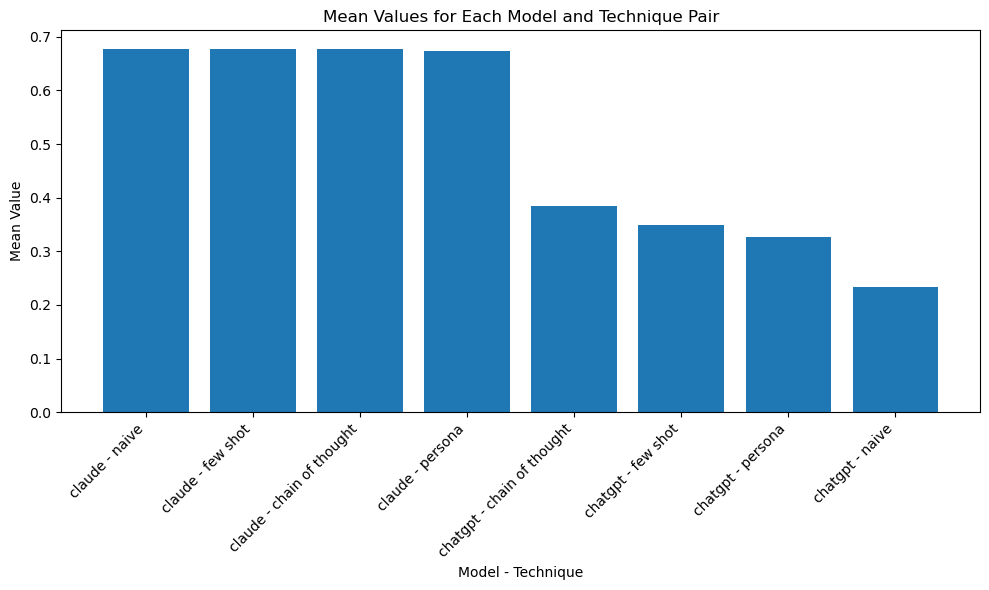

In [6]:
# Mean CodeBleu Score for each model and technique pairs.
mean_values = data.groupby(['Model', 'Techniques']).mean(numeric_only=True).reset_index().sort_values('CodeBleu', ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    x=[f"{m} - {t}" for m, t in zip(mean_values['Model'], mean_values['Techniques'])],
    height=mean_values.iloc[:, 2]  # assumes the 3rd column is the one you want to plot
)

plt.title('Mean Values for Each Model and Technique Pair')
plt.xlabel('Model - Technique')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

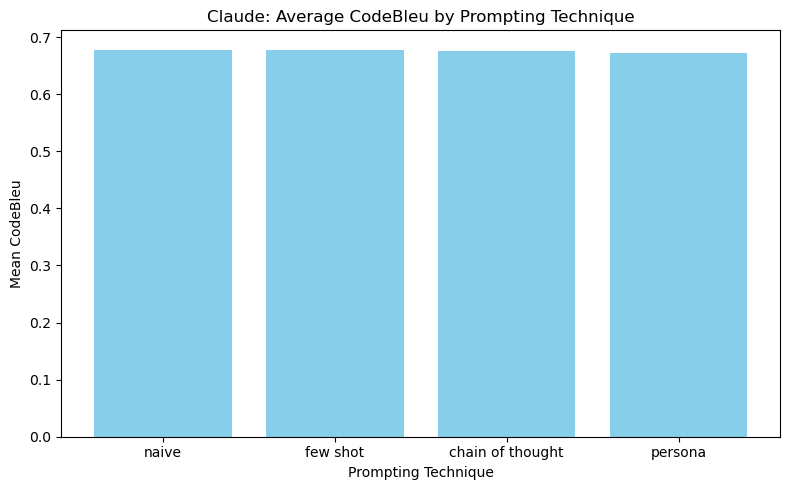

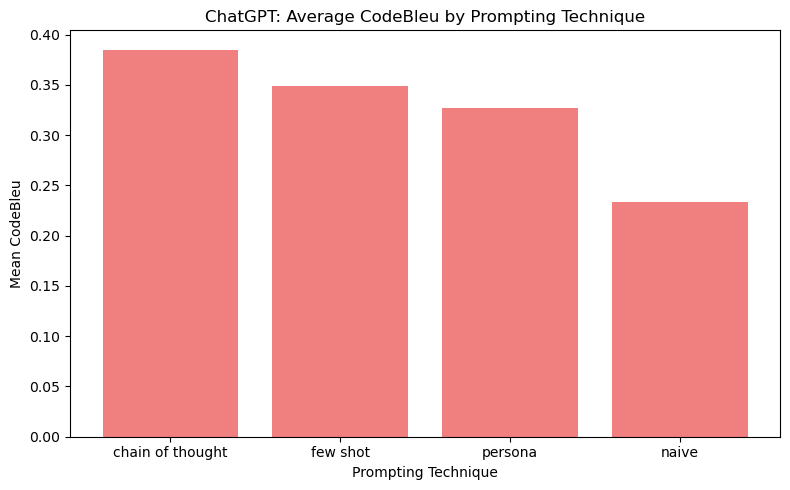

In [7]:
# Plot mean CodeBleu values for Claude only
claude_means = mean_values[mean_values['Model'] == 'claude']

plt.figure(figsize=(8, 5))
plt.bar(claude_means['Techniques'], claude_means['CodeBleu'], color='skyblue')
plt.xlabel('Prompting Technique')
plt.ylabel('Mean CodeBleu')
plt.title('Claude: Average CodeBleu by Prompting Technique')
plt.tight_layout()
plt.show()

# Plot mean CodeBleu values for ChatGPT only
chatgpt_means = mean_values[mean_values['Model'] == 'chatgpt']

plt.figure(figsize=(8, 5))
plt.bar(chatgpt_means['Techniques'], chatgpt_means['CodeBleu'], color='lightcoral')
plt.xlabel('Prompting Technique')
plt.ylabel('Mean CodeBleu')
plt.title('ChatGPT: Average CodeBleu by Prompting Technique')
plt.tight_layout()
plt.show()


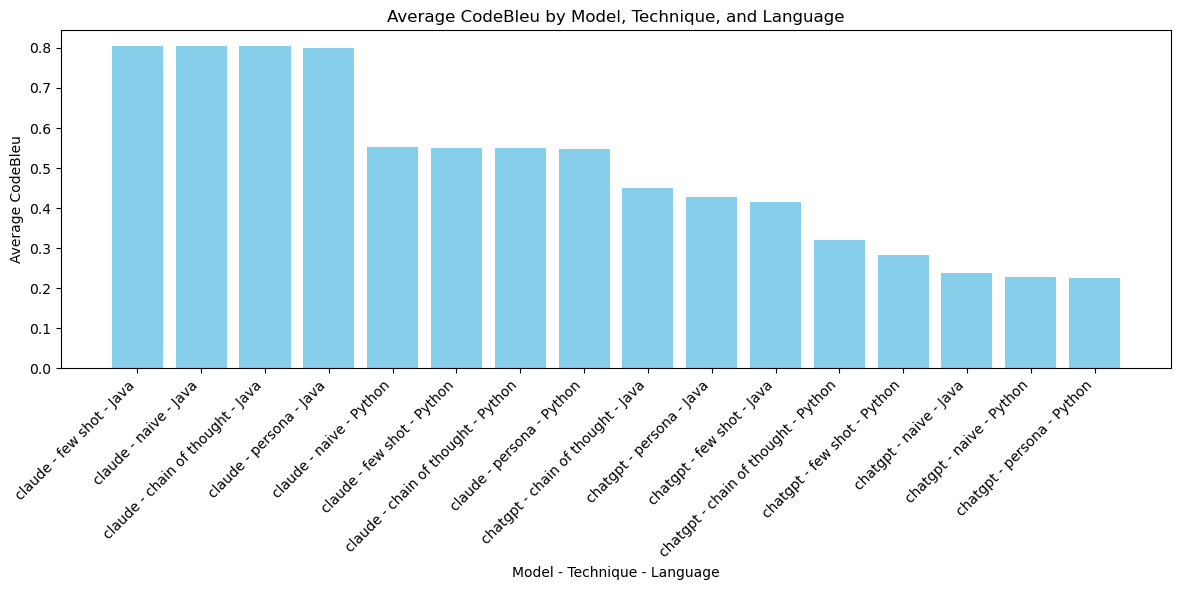

In [8]:
# Group by Model, Technique, and Language and plot
grouped = data.groupby(['Model', 'Techniques', 'Task Language'])['CodeBleu'].mean().reset_index().sort_values('CodeBleu', ascending=False)

grouped['Combo'] = grouped['Model'] + ' - ' + grouped['Techniques'] + ' - ' + grouped['Task Language']

plt.figure(figsize=(12, 6))
plt.bar(grouped['Combo'], grouped['CodeBleu'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model - Technique - Language')
plt.ylabel('Average CodeBleu')
plt.title('Average CodeBleu by Model, Technique, and Language')
plt.tight_layout()
plt.show()


## Testing for Statistical Difference between Techniques

In [11]:
grouped

,Model,Techniques,Task Language,CodeBleu,Combo
10,claude,few shot,Java,0.803660,claude - few shot - Java
12,claude,naive,Java,0.803660,claude - naive - Java
8,claude,chain of thought,Java,0.803613,claude - chain of thought - Java
14,claude,persona,Java,0.798967,claude - persona - Java
13,claude,naive,Python,0.552553,claude - naive - Python
11,claude,few shot,Python,0.550013,claude - few shot - Python
9,claude,chain of thought,Python,0.549173,claude - chain of thought - Python
15,claude,persona,Python,0.546820,claude - persona - Python
0,chatgpt,chain of thought,Java,0.450373,chatgpt - chain of thought - Java
6,chatgpt,persona,Java,0.429013,chatgpt - persona - Java


In [12]:
# Filter only Claude model data
claude_data = data[data['Model'] == 'claude']

# Keep only tasks that have both 'naive' and 'persona' techniques
pivot = claude_data.pivot_table(index='Task id', columns='Techniques', values='CodeBleu')

# Drop rows where either 'naive' or 'persona' is missing
pivot = pivot.dropna(subset=['naive', 'persona'])

# Perform paired t-test (matched by Task id)
t_stat, p_value = stats.ttest_rel(pivot['naive'], pivot['persona'])

print("Paired t-test for Claude model (naive vs persona):")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}")


Paired t-test for Claude model (naive vs persona):
t-statistic = 1.4699, p-value = 1.5235e-01


In [13]:
# Filter only Claude model data
claude_data = data[data['Model'] == 'claude']

# Pivot to get each Task id as a row and each technique as a column
pivot = claude_data.pivot_table(index='Task id', columns='Techniques', values='CodeBleu')

# Drop rows missing the naive technique (required as the baseline)
pivot = pivot.dropna(subset=['naive'])

# List of other techniques to compare with 'naive'
techniques = ['chain of thought', 'few shot', 'persona']

for tech in techniques:
    if tech in pivot.columns:
        subset = pivot.dropna(subset=[tech, 'naive'])
        t_stat, p_value = stats.ttest_rel(subset['naive'], subset[tech])
        print(f"Paired t-test for Claude model (naive vs {tech}):")
        print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}\n")
    else:
        print(f"Technique '{tech}' not found in data.\n")


Paired t-test for Claude model (naive vs chain of thought):
t-statistic = 1.3678, p-value = 1.8189e-01

Paired t-test for Claude model (naive vs few shot):
t-statistic = 1.1023, p-value = 2.7939e-01

Paired t-test for Claude model (naive vs persona):
t-statistic = 1.4699, p-value = 1.5235e-01



In [14]:
# Filter only ChatGPT model data
chatgpt_data = data[data['Model'] == 'chatgpt']

# Pivot so each Task id becomes a row and each prompting technique a column
pivot = chatgpt_data.pivot_table(index='Task id', columns='Techniques', values='CodeBleu')

# Drop rows missing the naive technique (the baseline)
pivot = pivot.dropna(subset=['naive'])

# List of techniques to compare to naive
techniques = ['chain of thought', 'few shot', 'persona']

# Perform paired t-tests for each technique compared to naive
from scipy import stats

for tech in techniques:
    if tech in pivot.columns:
        subset = pivot.dropna(subset=[tech, 'naive'])
        t_stat, p_value = stats.ttest_rel(subset['naive'], subset[tech])
        print(f"Paired t-test for ChatGPT model (naive vs {tech}):")
        print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4e}\n")
    else:
        print(f"Technique '{tech}' not found in data.\n")


Paired t-test for ChatGPT model (naive vs chain of thought):
t-statistic = -5.6812, p-value = 3.8317e-06

Paired t-test for ChatGPT model (naive vs few shot):
t-statistic = -3.8997, p-value = 5.2489e-04

Paired t-test for ChatGPT model (naive vs persona):
t-statistic = -3.1078, p-value = 4.1946e-03

